In [240]:
import sys, os
sys.path.append("../..")
sys.path.append("..")
sys.path.append(os.getcwd())

from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates



import numpy as np
import pandas as pd
import copy

from tslib.src import tsUtils
from tslib.src.synthcontrol.syntheticControl import RobustSyntheticControl
from tslib.tests import testdata

In [241]:


filename = r'C:\projects\RSC\tslib\tests\testdata\Chapter11ByState_norm.csv'


df = pd.read_csv(filename, index_col='years')
allColumns = df.columns.values    

In [242]:
pd.set_option('display.max_columns', 10)
df.head()

,Maine,Massachusets,New Hampshire,Rhode Island,Puerto Rico,...,Wyoming,Alabama,Florida,Georgia,WashingtonD.C.
years,,,,,,,,,,,
1999,3.33,3.01,3.42,5.11,4.60,...,4.19,6.99,4.99,7.42,5.24
2000,3.16,2.45,2.91,4.24,3.91,...,4.21,7.41,4.53,7.28,4.10
2001,3.54,2.76,3.13,4.62,3.74,...,5.06,8.71,5.33,8.33,4.43
2002,3.42,2.70,3.17,4.60,3.58,...,4.56,9.36,5.54,8.82,4.32
2003,3.58,2.83,3.45,4.25,3.68,...,4.93,9.46,5.57,9.30,4.00


In [243]:
states = df.columns.values.tolist()
StateKey = 'WashingtonD.C.'
states.remove(StateKey)
otherStates = states

yearStart = 1999
yearTrainEnd = 2007
yearTestEnd = 2009

p = 1.0

In [245]:
trainDF=df.head(9)
trainDF.reset_index(drop=True, inplace=True)
trainDF

,Maine,Massachusets,New Hampshire,Rhode Island,Puerto Rico,...,Wyoming,Alabama,Florida,Georgia,WashingtonD.C.
0,3.33,3.01,3.42,5.11,4.60,...,4.19,6.99,4.99,7.42,5.24
1,3.16,2.45,2.91,4.24,3.91,...,4.21,7.41,4.53,7.28,4.10
2,3.54,2.76,3.13,4.62,3.74,...,5.06,8.71,5.33,8.33,4.43
3,3.42,2.70,3.17,4.60,3.58,...,4.56,9.36,5.54,8.82,4.32
4,3.58,2.83,3.45,4.25,3.68,...,4.93,9.46,5.57,9.30,4.00
5,3.45,2.87,3.60,3.87,3.41,...,4.94,9.31,4.96,8.75,3.44
6,5.04,4.15,4.69,5.49,3.37,...,6.46,10.54,6.09,8.96,4.18
7,1.01,1.30,1.47,1.53,1.39,...,1.35,4.28,1.43,4.32,0.94
8,1.75,2.12,2.27,2.67,1.98,...,1.52,5.16,2.28,5.26,1.21


In [246]:
testDF=df.tail(3)
testDF.reset_index(drop=True, inplace=True)
testDF

,Maine,Massachusets,New Hampshire,Rhode Island,Puerto Rico,...,Wyoming,Alabama,Florida,Georgia,WashingtonD.C.
0,1.75,2.12,2.27,2.67,1.98,...,1.52,5.16,2.28,5.26,1.21
1,2.30,2.55,2.99,4.09,2.30,...,1.59,6.34,3.69,6.35,1.47
2,2.94,3.18,3.95,4.84,2.86,...,2.48,7.43,5.24,7.65,1.96


70
9


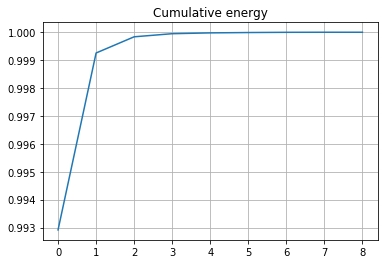

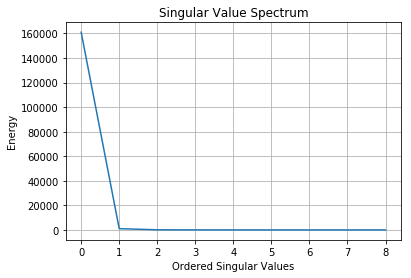

In [271]:
(U, s, Vh) = np.linalg.svd((trainDF) - np.mean(trainDF))
s2 = np.power(s, 2)
spectrum = np.cumsum(s2)/np.sum(s2)

plt.plot(spectrum)
plt.grid()
plt.title("Cumulative energy")
plt.figure()
plt.plot(s2)
plt.grid()


plt.xlabel("Ordered Singular Values") 
plt.ylabel("Energy")


plt.title("Singular Value Spectrum")


In [263]:
singvals = 4
rscModel = RobustSyntheticControl(StateKey, singvals, len(trainDF), probObservation=1.0, modelType='svd', svdMethod='numpy', otherSeriesKeysArray=otherStates)
rscModel.fit(trainDF)
denoisedDF = rscModel.model.denoisedDF()

In [264]:
predictions = []
predictions = np.dot(testDF[otherStates], rscModel.model.weights)
actual = df[[StateKey]]
actual.reset_index(inplace=True)
years=actual['years'].astype(str).tolist()
trainingYears=years[0:9]
testYears=years[8:11]
model_fit = np.dot(trainDF[otherStates][:], rscModel.model.weights)

actual=actual.reset_index(drop=True)


['1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009']
['1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007']
['2007', '2008', '2009']
[4.79496743 4.24300433 4.64297126 4.46879592 3.99993015 3.59393475
 4.08210999 0.74009435 1.12171342]
    years  WashingtonD.C.
0    1999            5.24
1    2000            4.10
2    2001            4.43
3    2002            4.32
4    2003            4.00
5    2004            3.44
6    2005            4.18
7    2006            0.94
8    2007            1.21
9    2008            1.47
10   2009            1.96
[1.12171342 2.02424817 3.28201687]


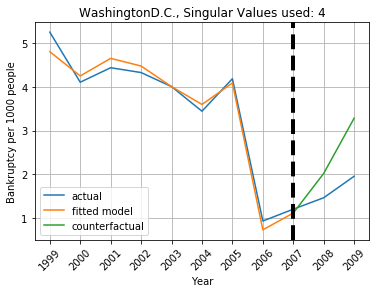

In [265]:
fig, ax = plt.subplots(1,1)
tick_spacing = 1
# this is a bug in matplotlib
label_markings = np.insert(years[::tick_spacing], 0, 'dummy')

ax.set_xticks(np.arange(len(label_markings)))
ax.set_xticklabels(label_markings, rotation=45)
ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

plt.plot(years, actual[StateKey] ,label='actual')
plt.xlabel('Year')
plt.ylabel('Bankruptcy per 1000 people')
plt.plot(trainingYears, model_fit, label='fitted model')
plt.plot(testYears, predictions, label='counterfactual')
plt.title(StateKey+', Singular Values used: '+str(singvals))

xposition = pd.to_datetime(yearTrainEnd,  errors='coerce')
plt.axvline(x=str(yearTrainEnd), color='k', linestyle='--', linewidth=4)
plt.grid()
plt.legend()